Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)

Ingestion

In [3]:
path = r'../data/processed/cleaned_data.csv'
df_telco = pd.read_csv(path)
df = df_telco.copy()
df.head()

,Unnamed: 0,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,1,5575-gnvde,male,0,no,no,34,yes,no,dsl,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,2,3668-qpybk,male,0,no,no,2,yes,no,dsl,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


Experimentation

Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
df_trainfull, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_trainfull, test_size=0.33, random_state=11)

X_train, X_test, X_val = df_train.iloc[:,1:-1] , df_test.iloc[:,1:-1] , df_val.iloc[:,1:-1]
y_train, y_test, y_val = df_train.iloc[:,-1] , df_test.iloc[:,-1] , df_val.iloc[:,-1]

EDA

In [5]:
categorical_features = ['gender', 'seniorcitizen', 'partner', 'dependents', #'customerid',
                        'phoneservice', 'multiplelines', 'internetservice', #'tenure',
                        'onlinesecurity', 'onlinebackup', 'deviceprotection', 
                        'techsupport', 'streamingtv', 'streamingmovies', 
                        'contract', 'paperlessbilling', 'paymentmethod', 
                        #'monthlycharges', 'totalcharges', 
                        # 'churn'
                        ]
                    
numerical_features = ['tenure', 'monthlycharges', 'totalcharges']

Feature Engineering

In [6]:
train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
from sklearn.feature_extraction import DictVectorizer
dv= DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

test_dict = df_test[categorical_features + numerical_features].to_dict(orient='records')
val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_test = dv.transform(test_dict)
X_val = dv.transform(val_dict)

Classification

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=1)
clf_log = model.fit(X_train, y_train)

def getscore(X,y, cutoff):
    prob  = clf_log.predict_proba(X)[:,1]
    pred  = [1* (x >= cutoff) for x in prob]
    score = (pred == y).mean()
    return prob, pred, score

print("Model Accuracy Training Set   : {:.2f}".format( getscore(X_train, y_train, 0.5)[2] ))
print("Model Accuracy Validation Set : {:.2f}".format( getscore(X_val, y_val, 0.5)[2] ))
print("Model Accuracy Testing Set    : {:.2f}".format( getscore(X_test, y_test, 0.5)[2] ))

Model Accuracy Training Set   : 0.80
Model Accuracy Validation Set : 0.80
Model Accuracy Testing Set    : 0.81


Model Interpretation

In [8]:
df_mc = pd.DataFrame({'FEATURES' : dv.get_feature_names_out(), 'COEFFICIENTS' : clf_log.coef_[0].round(3)})
df_mc.sort_values(by='COEFFICIENTS', ascending=False)

,FEATURES,COEFFICIENTS
0,contract=month-to-month,0.563
11,internetservice=fiber_optic,0.317
33,seniorcitizen,0.297
20,onlinesecurity=no,0.258
40,techsupport=no,0.178
29,paymentmethod=electronic_check,0.175
17,onlinebackup=no,0.136
15,multiplelines=no_phone_service,0.127
31,phoneservice=no,0.127
5,deviceprotection=no,0.100


Evaluation Metrics

In [9]:
from sklearn.metrics import accuracy_score

df_acc = {'CUTOFF':[], 'SCORE':[]}
cutoff_list = np.linspace(0,1,11)
y_prob = clf_log.predict_proba(X_val)[:,1]

for cutoff in cutoff_list:
    y_pred = [1*(x >= cutoff) for x in y_prob]
    score = accuracy_score(y_val, y_pred)

    df_acc['CUTOFF'].append(cutoff)
    df_acc['SCORE'].append(score.round(3))
    
df_acc = pd.DataFrame(df_acc)
df_acc

,CUTOFF,SCORE
0,0.0,0.261
1,0.1,0.595
2,0.2,0.690
3,0.3,0.755
4,0.4,0.782
5,0.5,0.802
6,0.6,0.790
7,0.7,0.774
8,0.8,0.742
9,0.9,0.739


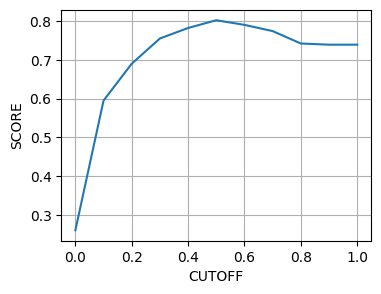

In [10]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_acc,
             x='CUTOFF',
             y='SCORE')
plt.grid(True)

Dummy Model Metrics

In [11]:
y_dummy = [1*False for x in y_val]
print('Accuracy of the dummy Model : {:.3f}'.format(accuracy_score(y_dummy, y_val)))

Accuracy of the dummy Model : 0.739


Confusion Matrix

<Axes: >

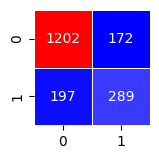

In [12]:
from sklearn.metrics import confusion_matrix
y_prob = clf_log.predict_proba(X_val)[:,-1]
threshold = 0.5
y_pred = [ 1*(x >= threshold) for x in y_prob]
cm_model = confusion_matrix(y_pred, y_val).T
plt.figure(figsize=(1.5,1.5))
sns.heatmap(data= cm_model , annot=True, fmt=".0f", linewidth=.5, cmap='bwr',cbar=False,)


<Axes: >

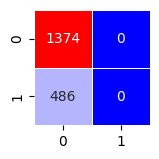

In [13]:
plt.figure(figsize=(1.5,1.5))
cm_dummy = confusion_matrix([False for x in y_val], y_val).T
sns.heatmap(data= cm_dummy , annot=True, fmt=".0f", linewidth=.5, cmap='bwr',cbar=False,)

ROC

In [14]:
y_prob = clf_log.predict_proba(X_val)[:,1]
y_dummpy = [0 for x in clf_log.predict_proba(X_val)[:,1]]

In [15]:
threshold_list = np.linspace(0,1,101)

df_metrics = {'THRESHOLD' : [],
              'TP' :[],
              'FP' :[],
              'TN' :[],
              'FN' :[],
              'TPR' :[],
              'FPR' :[],
              }

for threshold in threshold_list:

    tp = ((y_prob >= threshold) & (y_val == 1)).sum()
    fp = ((y_prob >= threshold) & (y_val == 0)).sum()
    tn = ((y_prob <  threshold) & (y_val == 0)).sum()
    fn = ((y_prob <  threshold) & (y_val == 1)).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    df_metrics['THRESHOLD'].append(threshold)
    df_metrics['TP'].append(tp)
    df_metrics['FP'].append(fp)
    df_metrics['TN'].append(tn)
    df_metrics['FN'].append(fn)
    df_metrics['TPR'].append(tpr)
    df_metrics['FPR'].append(fpr)

df_metrics = pd.DataFrame(df_metrics)[::10]

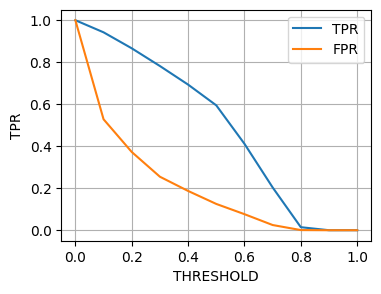

In [16]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_metrics, x='THRESHOLD', y='TPR',label='TPR')
sns.lineplot(data=df_metrics, x='THRESHOLD', y='FPR',label='FPR')
plt.legend(); plt.grid(True)

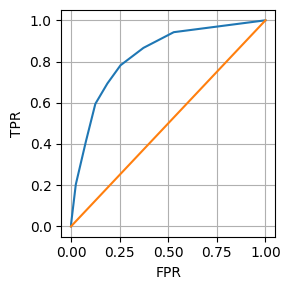

In [17]:
plt.figure(figsize=(3,3))
sns.lineplot(data=df_metrics, x='FPR', y='TPR')
sns.lineplot(x=[0,1],y=[0,1])
plt.grid(True); plt.tight_layout()

AUC

In [18]:
from sklearn.metrics import auc
auc_score = auc(df_metrics['FPR'], df_metrics['TPR']).round(3)
print(f"AUC Score : {auc_score}")

AUC Score : 0.829


K Fold cross validation

In [19]:
def train(df, y, c=1.0):
      X = df[categorical_features + numerical_features].to_dict(orient='records')
      encoder = DictVectorizer(sparse=False)
      dv = encoder.fit(X)
      X_en = dv.transform(X)

      model = LogisticRegression(solver='liblinear', C=c)
      model = model.fit(X_en, y)
      return dv, model

def predict(df, dv, model):
      X = df[categorical_features + numerical_features].to_dict(orient='records')
      X_en = dv.transform(X)

      y_prob = model.predict_proba(X_en)[:,1]
      return y_prob

In [20]:
auc_scores = []

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
kfold = KFold(n_splits=10,
              shuffle=True,
              random_state=1)

for train_idx, val_idx in kfold.split(df_trainfull):

      df_train = df_trainfull.iloc[train_idx]
      df_val = df_trainfull.iloc[val_idx]

      y_train = df_train.churn.values
      y_val = df_val.churn.values

      dv, model = train(df_train, y_train)
      y_prob = predict(df_val, dv, model)

      auc = roc_auc_score(y_val, y_prob)
      auc_scores.append(auc)

print('AUC score = %0.3f ± %0.5f' % (np.mean(auc_scores), np.std(auc_scores)))

AUC score = 0.842 ± 0.01227


Paramter Tuning

In [21]:
parameters_dict = {'C': [0.001, 0.01, 0.1, 0.5, 1.0, 10],
                   'AUC_MEAN' : [],
                   'AUC_STD': [],
                   'AUC' : [],
                   }
k_folds = 5
kfold = KFold(n_splits=10,
              shuffle=True,
              random_state=1)

for c in parameters_dict['C']:
    for train_idx, val_idx in kfold.split(df_trainfull):

      df_train = df_trainfull.iloc[train_idx]
      df_val = df_trainfull.iloc[val_idx]

      y_train = df_train.churn.values
      y_val = df_val.churn.values

      dv, model = train(df_train, y_train, c=c)
      y_prob = predict(df_val, dv, model)

      auc = roc_auc_score(y_val, y_prob).round(3)
      auc_scores.append(auc)
      auc_mean = np.mean(auc_scores).round(3)
      auc_std = np.std(auc_scores).round(5)

    parameters_dict['AUC'].append(auc_scores)
    parameters_dict['AUC_MEAN'].append(auc_mean)
    parameters_dict['AUC_STD'].append(auc_std)

print( pd.DataFrame(parameters_dict))

        C  AUC_MEAN  AUC_STD  \
0   0.001     0.834  0.01644   
1   0.010     0.836  0.01541   
2   0.100     0.838  0.01482   
3   0.500     0.838  0.01446   
4   1.000     0.839  0.01419   
5  10.000     0.839  0.01398   

                                                 AUC  
0  [0.8493392490816277, 0.8413366336633662, 0.859...  
1  [0.8493392490816277, 0.8413366336633662, 0.859...  
2  [0.8493392490816277, 0.8413366336633662, 0.859...  
3  [0.8493392490816277, 0.8413366336633662, 0.859...  
4  [0.8493392490816277, 0.8413366336633662, 0.859...  
5  [0.8493392490816277, 0.8413366336633662, 0.859...  


In [22]:
y_train = df_trainfull.churn.values
y_test = df_test.churn.values

dv, model = train(df_trainfull, y_train, c=0.5)
y_prob = predict(df_test, dv =dv, model = model)

auc = roc_auc_score(y_test, y_prob)
print('AUC test set : {:.3f}'.format(auc))

AUC test set : 0.858


Deployments

In [29]:
df_telco['customerid'][df_telco['customerid'] == '8879-zkjof'].index

Index([3381], dtype='int64')

In [68]:
df_check = df_telco[3381:3382]
out = df_check.to_json(orient='records')[1:-1].replace('},{', '} {')
with open('../tests/payload.json', 'w') as f:
    f.write(out)

In [77]:
payload = {
      "Unnamed: 0": 3381,
      "customerid": "8879-zkjof",
      "gender": "female",
      "seniorcitizen": 0,
      "partner": "no",
      "dependents": "no",
      "tenure": 41,
      "phoneservice": "yes",
      "multiplelines": "no",
      "internetservice": "dsl",
      "onlinesecurity": "yes",
      "onlinebackup": "no",
      "deviceprotection": "yes",
      "techsupport": "yes",
      "streamingtv": "yes",
      "streamingmovies": "yes",
      "contract": "one_year",
      "paperlessbilling": "yes",
      "paymentmethod": "bank_transfer_(automatic)",
      "monthlycharges": 79.85,
      "totalcharges": 3320.75,
      "churn": 0
}

Prediction 

In [81]:
result = predict(df = pd.DataFrame([payload]),
                  dv = dv,
                  model = model)

print("PROBABILITY : {}".format(result[0].round(3)))
print("VERDICT     : {}".format(result[0] >= 0.5))

PROBABILITY : 0.062
VERDICT     : False


Saving the model

In [61]:
import pickle
with open('../bin/churn-model.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)